# 1. Environment Setup
   
First, ensure you have the necessary libraries installed. You will need PyTorch, torchvision, and other libraries like matplotlib for visualization.

In [1]:
%%capture
!pip install tensorflow pillow numpy

# 2. Data Collection and Preprocessing
You need a dataset with images and corresponding textual descriptions. The Microsoft COCO dataset is a popular choice for this type of task.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model


def load_images(image_paths, target_size):
    images = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)
        image = image / 255.0
        images.append(image)
    return np.array(images)

def preprocess_text(descriptions, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(descriptions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

image_paths = ["/content/img.jfif", "/content/img2.jfif"]
descriptions = ["a description of image1", "a description of image2"]

target_size = (128, 128)
images = load_images(image_paths, target_size)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)
max_length = max(len(desc.split()) for desc in descriptions)
text_sequences = preprocess_text(descriptions, tokenizer, max_length)


# 3. Model Architecture
Implementing a basic GAN structure. For a more sophisticated model, you can use StackGAN or Stable Diffusion.

Generator and Discriminator

In [ ]:
def build_generator(latent_dim, channels):
    model = Sequential()

    model.add(Dense(128 * 16 * 16, activation="relu", input_dim=latent_dim))
    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator(img_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Example usage
latent_dim = 100
img_shape = (128, 128, 3)
channels = 3

generator = build_generator(latent_dim, channels)
discriminator = build_discriminator(img_shape)

generator.summary()
discriminator.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 3)         3533443   
                                                                 
Total params: 3533443 (13.48 MB)
Trainable params: 3533059 (13.48 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 1)                 464193    
                                                                 


In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

def build_generator(latent_dim, channels):
    model = Sequential()

    model.add(Dense(128 * 16 * 16, activation="relu", input_dim=latent_dim))
    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    # Add another UpSampling2D layer to match discriminator's input
    model.add(UpSampling2D())
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator(img_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Example usage
latent_dim = 100
img_shape = (128, 128, 3)
channels = 3

generator = build_generator(latent_dim, channels)
discriminator = build_discriminator(img_shape)

generator.summary()
discriminator.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 128, 128, 3)       3533443   
                                                                 
Total params: 3533443 (13.48 MB)
Trainable params: 3533059 (13.48 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 1)                 464193    
                                                                 


# Training

In [ ]:
import tensorflow.keras.backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Initialize optimizer after creating the 'combined' model
# Use the legacy optimizer as suggested in the error message
optimizer = tf.keras.optimizers.legacy.RMSprop(lr=0.1)

discriminator.compile(loss=wasserstein_loss, optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss=wasserstein_loss, optimizer=optimizer)

# Training parameters
epochs = 100
batch_size = 32
save_interval = 200

# Real and fake labels
real = -np.ones((batch_size, 1))
fake = np.ones((batch_size, 1))

# Training loop
for epoch in range(epochs):
    idx = np.random.randint(0, images.shape[0], batch_size)
    imgs = images[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch(noise, real)

    if epoch % save_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")


1/1 [==============================] - 0s 17ms/step


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7a5350290550>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


0 [D loss: -0.4665853977109901 | D accuracy: 0.0] [G loss: -1.2131214088828557e-10]
1/1 [==============================] - 0s 17ms/step


# Testing

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Set the latent dimension size used during training
latent_dim = 100

# Text description for the image
description = "bird"

# Preprocess the description
text_sequence = preprocess_text(description, tokenizer, max_length)

# Generate image
noise = np.random.normal(0, 1, (1, latent_dim))
generated_image = generator.predict(noise)

# Post-process the generated image
generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
generated_image_pil = Image.fromarray(generated_image[0])

# Display the image
generated_image_pil


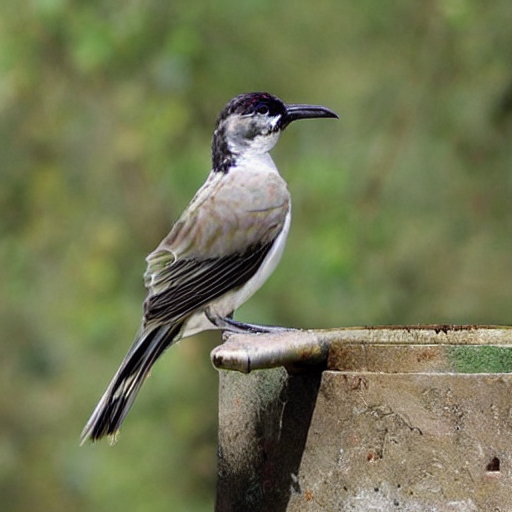

In [ ]:
generated_image